In [1]:
################################################################################
######################    Unsupervised learning - PDF    #######################
################################################################################
### Load necessary modules -------------------------------
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
plt.style.use('ggplot')
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})
import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn import mixture
import matplotlib as mpl
import unsupervisedtools as UT
import itertools
from scipy import linalg

In [2]:
# Import data
df = pd.read_csv('MultivariateDensityEstimation.dat', sep=' ')
df.head()

,X1,X2,Y
0,1.693278,8.674574,0.0
1,1.546725,7.899898,0.0
2,1.702522,8.135700,0.0
3,2.321894,7.855147,0.0
4,1.694677,8.511083,0.0


In [3]:
X = df[['X1','X2']]
Y = df[['Y']]

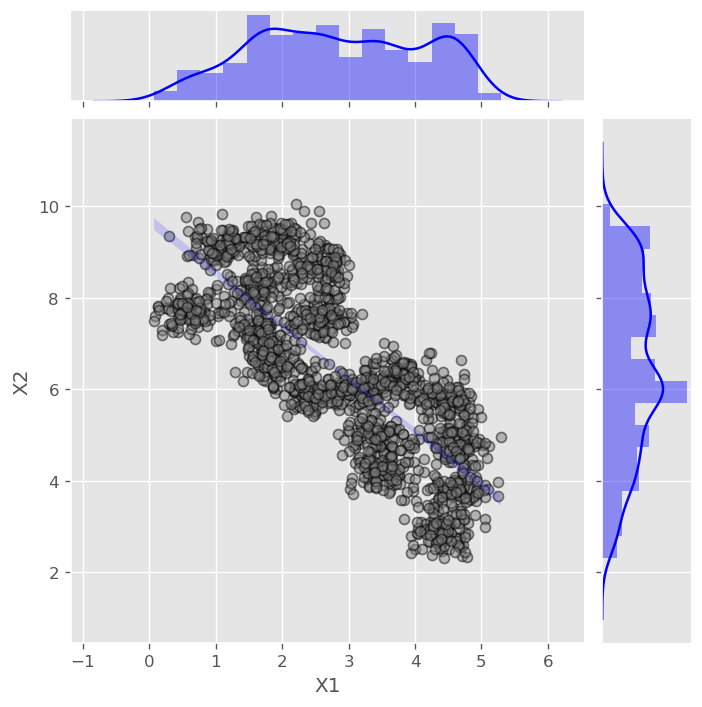

In [4]:
# Check relations between X1 and X2
sns.jointplot(data=df, x='X1', y='X2', kind='reg', color='blue',joint_kws = {'scatter_kws':dict(alpha=0.5, color='gray', edgecolor='black')})
plt.show()

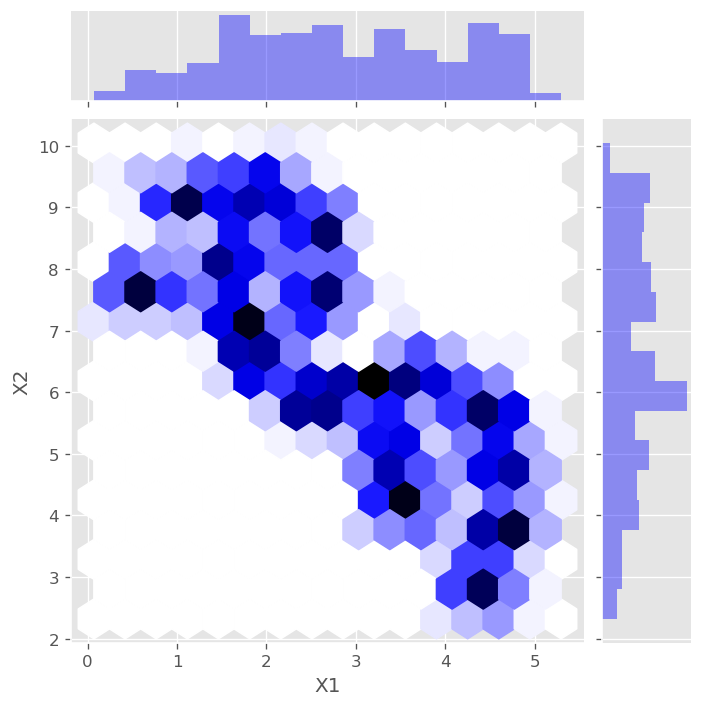

In [5]:
# Check relations between X1 and X2
sns.jointplot(data=df, x='X1', y='X2', kind='hex', color='blue')
plt.show()

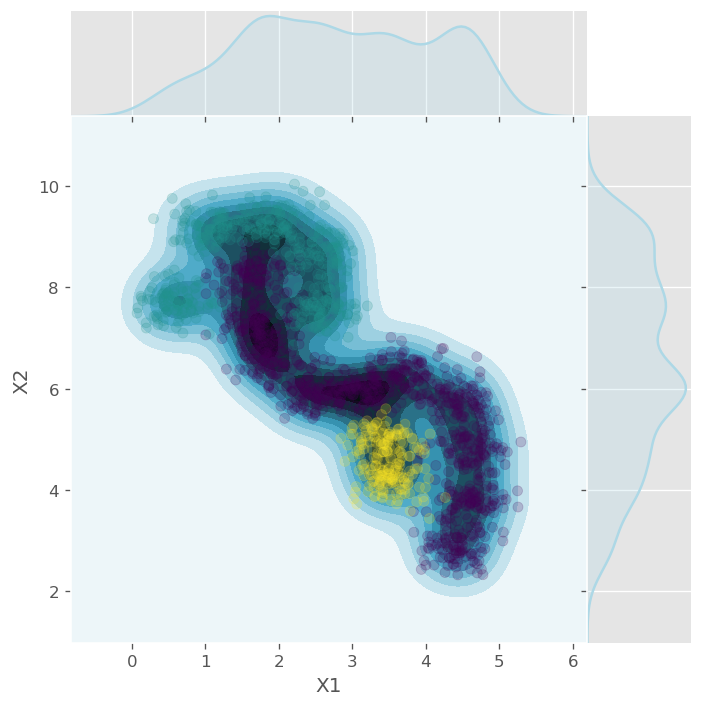

In [6]:
# Check relations between X1 and X2
g = sns.jointplot(data=df, x='X1', y='X2', kind='kde', space=0, color='lightblue')
g.ax_joint.scatter(df.X1, df.X2, c=df.Y, alpha=0.2) # Add points to the 2d-density plot
plt.show()

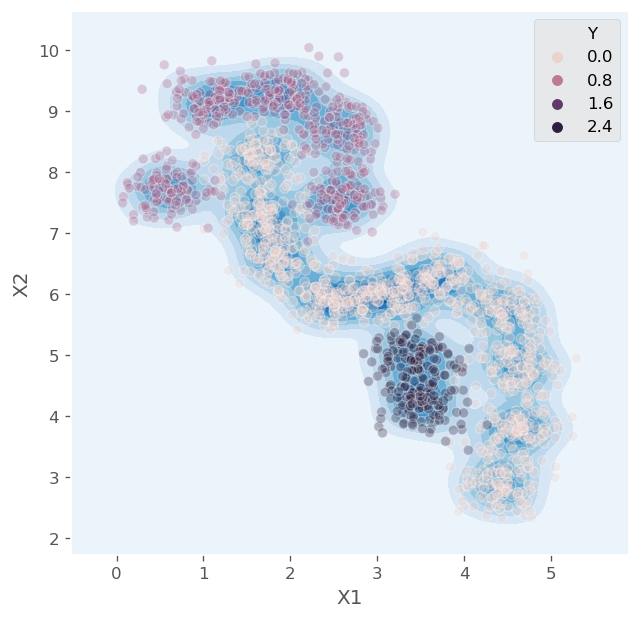

In [7]:
# Only the inner plot
f, ax = plt.subplots(figsize=(6, 6))
sns.kdeplot(df.X1, df.X2, ax=ax, cmap="Blues", shade=True, bw=.2)
sns.scatterplot(x='X1', y='X2', data=df, hue='Y', alpha=0.3)
plt.show()

In [8]:
# Kernel Density Estimation (KDE) -----------------
# We are using a gaussian kernel, but the available options are: ['gaussian', 'tophat', 'epanechnikov, 'exponential', 'linear', 'cosine']
# Check https://scikit-learn.org/stable/modules/density.html
kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(X)

In [9]:
# Evaluate the kernel density estimate
xx, yy = np.mgrid[df.X1.min():df.X1.max():100j, df.X2.min():df.X2.max():100j]
positions = pd.DataFrame(np.vstack([xx.ravel(), yy.ravel()]).transpose(), columns=['X1','X2'])
f = np.reshape(np.exp(kde.score_samples(positions).T), xx.shape)

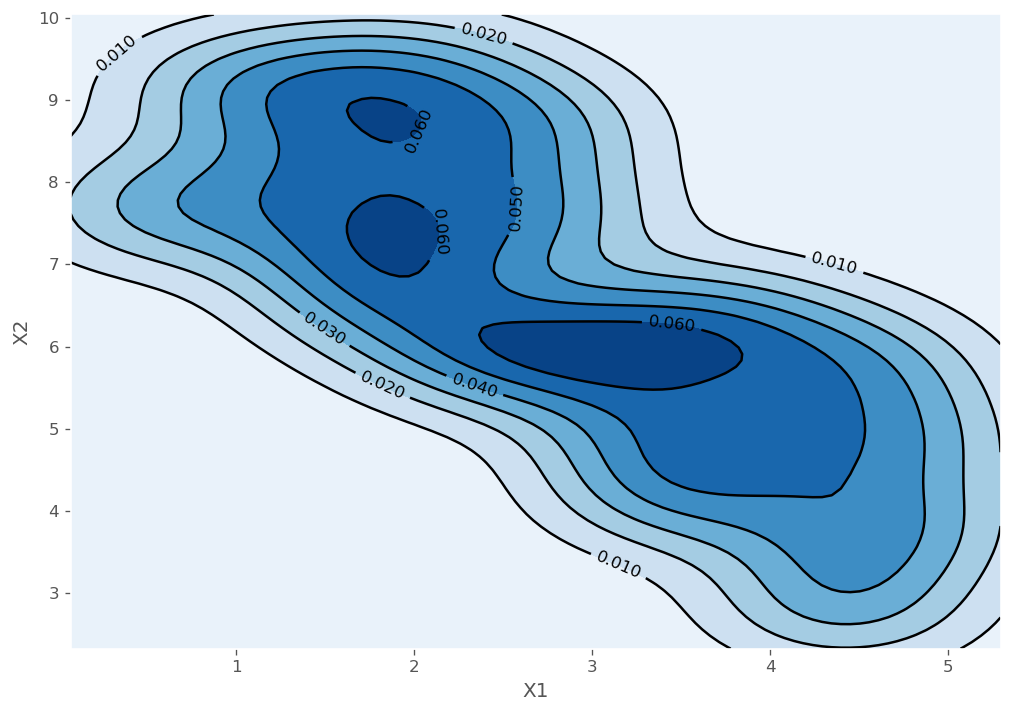

In [10]:
fig, ax = plt.subplots()
# Contourf plot
cfset = ax.contourf(xx, yy, f, cmap='Blues')
# Contour plot
cset = ax.contour(xx, yy, f, colors='k')
# Label plot
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('X1')
ax.set_ylabel('X2')

plt.show()

In [11]:
# Convert dataframe to array to perform gaussian mixture
X = X.values

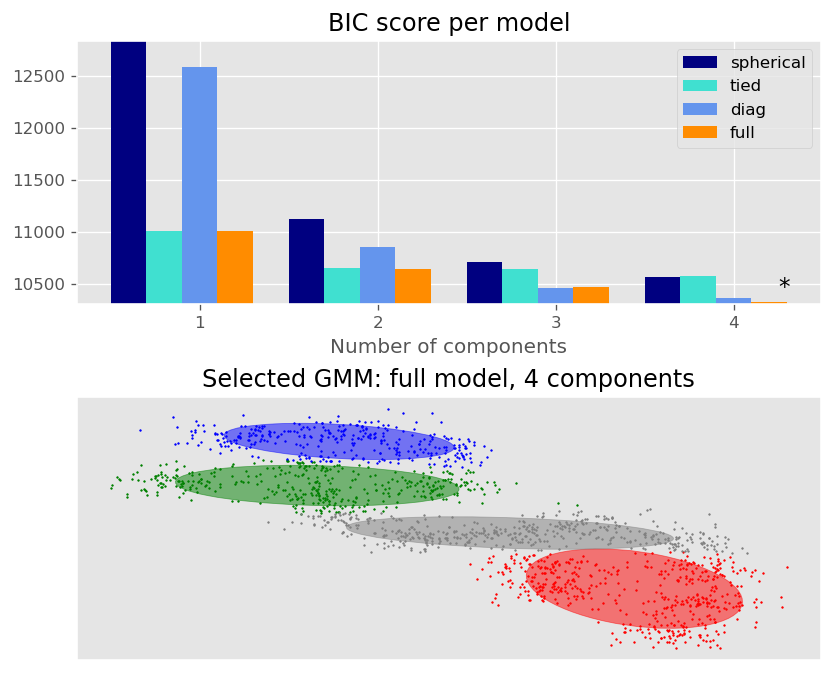

In [12]:
## Use gaussian mixture if you want to specify number of kernels
lowest_bic = np.infty
bic = []
#n_components_range = range(1, 7)
n_components_range = range(1, 5)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                              covariance_type=cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue', 'darkorange', 'green', 'red', 'blue', 'gray', 'brown'])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(X)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                           color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)

plt.xticks(())
plt.yticks(())
plt.title('Selected GMM: full model, %i components' % clf.n_components)
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()